# Trace Estimator  
https://doi.org/10.1016/0377-0427(96)00018-0 
## b) Algorithm 1 with Gauss-Radau quadrature

In [1]:
import numpy as np 
from math import fabs
import matplotlib.pyplot as plt
from warnings import warn

n_A = 5
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

vec1 = -1*np.ones(n_A-1)
vec2 = 2*np.ones(n_A)
vec3 = -1*np.ones(n_A-1)
A = tridiag(vec1, vec2, vec3)
A



array([[ 2., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.],
       [ 0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1.,  2.]])

In [43]:
def T_tilda(T, gamma, a):
    """
    Implements the correction mentioned in Remark 3. 
    INPUT:
    - T: T_j
    - gamma: gamma_j
    - a: scalar, a or b
    OUTPUT:
    - T_tilda_j: matrix as defined page 76 of Bai et al., for the Gauss-Radau case.
    """
    e_j = np.zeros(T.shape[0])
    e_j[-1] = 1
    delta = np.linalg.solve(T-a*np.eye(T.shape[0]), gamma*gamma*e_j) # tridiagonal system, could be written without np.linalg.solve maybe
    phi = a + delta[-1]
    temp_left = np.vstack((T, gamma*e_j))
    temp_right = np.expand_dims(np.append(gamma*e_j, phi),1)
    return np.hstack((temp_left, temp_right))

def Gerschgorin(A):
    """Simple way to find a and b in R such that the eigenvalues of A are in [a,b].
    INPUT:
    - square matrix A
    OUTPUT:
    - array: [a,b]
    """
    for i in range(A.shape[0]):
        r = 0
        pivot = A[i,i]
        for j in range(A.shape[1]):
            if i!=j:
                r += fabs(A[i][j])

        if i==0:
            a = pivot-r
            b = pivot+r
        else:
            if (pivot-r)<a:
                a = pivot-r
            if (pivot+r)>b:
                b = pivot+r

    return np.array([a, b])    


def check_new_eig(a, eigs, tol=1e-3):
    """
    Checks if a is in array eigs.
    INPUT: 
    - a: number
    - eigs: sorted eigenvalues
    - tol: tolerance 
    OUTPUT:
    - bool: true if a is in eigs, else false.
    """
    if len(eigs)==1:
        if np.abs(a-eigs[0])<tol:
            return True
        else:
            print("IN CHECK_NEW_EIG: a=", a)
            print("IN CHECK_NEW_EIG: eigs[0]=", eigs[0])
            return False
    else:    
        n = int(len(eigs)/2)
        if a>=eigs[n]:
            return check_new_eig(a, eigs[n:])
        else:
            return check_new_eig(a, eigs[:n])  
        
def check_ortho(X, tol=1e-8):
    """
    Checks if the columns of X are orthogonal to one another.
    INPUT:
    - X: 2d matrix, its columns are the ones we want to check the orthogonality of
    OUTPUT:
    - bool: 
        - True: the vectors are orthogonal
        - False: they are not.
    """
    prod = X @ X.T
    for i in range(prod.shape[0]):
        for j in range(prod.shape[1]):
            if i==j:
                if np.abs(prod[i,j]-1)>tol:
                    return False
            else:
                if np.abs(prod[i,j])>tol:
                    return False
    return True


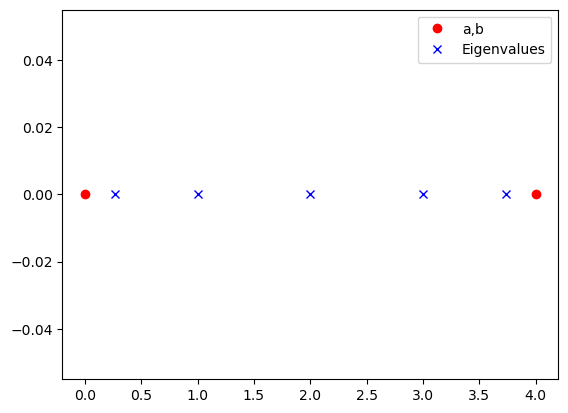

In [44]:
# Test Gerschogorin algo: [a,b] should contain all eigenvalues of A.
a, b = Gerschgorin(A)
eig = np.linalg.eigvals(A)
plt.plot([a,b], np.zeros(2), 'ro')
plt.plot(eig, np.zeros(len(eig)), 'bx')
plt.legend(['a,b', 'Eigenvalues'])

In [45]:
# test T_tilda function: a should become an eigenvalue of T_tilda_j.
a = 1e-3
gamma = 3
T_tilda_j = T_tilda(A, gamma, a)
print("A=\n", A)
print("A_tilda=\n", T_tilda_j)


eigs = np.linalg.eigvals(T_tilda_j)
in_eigs = False
for i in range(len(eigs)):
    if(np.abs(a-eigs[i])<1e-7):
        in_eigs=True
print("Is 'a' in the eigenvalues of T_tilda_j:", in_eigs) 
print(check_new_eig(a, np.sort(eigs)))

A=
 [[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]
A_tilda=
 [[ 2.         -1.          0.          0.          0.          0.        ]
 [-1.          2.         -1.          0.          0.          0.        ]
 [ 0.         -1.          2.         -1.          0.          0.        ]
 [ 0.          0.         -1.          2.         -1.          0.        ]
 [ 0.          0.          0.         -1.          2.          3.        ]
 [ 0.          0.          0.          0.          3.          7.51479186]]
Is 'a' in the eigenvalues of T_tilda_j: True
True


In [78]:
def algorithm_1(A, u, function, maxit=50, epsilon=1e-5):
    # try with another A, check that x_j are orthogonal, check that Gauss works
    '''
    Implements algorithm 1 from Bai et al. It computes a lower/upper bound of the quantity u^T f(A) u by using the Gauss-Radau rules
    INPUT:
    - A: a symmetric positive definite matrix of size n times n for some n, with eigenvalues in [a,b]
    - u: vector of size n 
    - f: smooth function in the interval [a,b]
    - maxit: maximum number of iteration
    - epsilon: tolerance between two iterations
    
    OUTPUT:
    - [U,L]: Upper and Lower bound of the quantity u^T f(A) u by using the Gauss-Radau rule.
    '''
    # Remark 1:
    interval = Gerschgorin(A)
    if interval[0]<=0:
        interval[0] = 1e-4
    print("a =", interval[0])
    print("b =", interval[1])

    # set the first variables
    x_j2 = 0
    x_j1 = u/np.linalg.norm(u)    
    gamma_j = 0
    I_j = np.zeros(2)
    I_j1 = np.zeros(2)
    X = [x_j1]

    for j in range(maxit):
        alpha_j = x_j1.T @ A @ x_j1
        r_j = A @ x_j1 - alpha_j*x_j1 - gamma_j*x_j2
        gamma_j = np.linalg.norm(r_j)

        # build T_j:
        if j==0:
            T_j = np.array([alpha_j])
        else:
            # print("T_j shape:", T_j.shape)
            # horizontal array [0, ..., 0, gamma_j
            temp_h = np.expand_dims(np.zeros(T_j.shape[0]),1)
            temp_h[-1] = gamma_j
            # print("temp h shape:",temp_h.shape)
            # vertical array [0, ..., 0, gamma_j, alpha_j].T
            temp_v = np.expand_dims(np.zeros(T_j.shape[0] + 1),1)
            temp_v[-1] = alpha_j
            temp_v[-2] = gamma_j
            # print("temp v shape:", temp_v.shape)
            # new T_j:
            T_j = np.hstack((np.vstack((T_j, temp_h.T)), temp_v))
            print("T_j:", T_j)
        
        # for Gauss Radau, a or b have to be zeros of the polynomial, i.e. must be eigenvalues of T_tilda_j:
        for i in range(2): # for lower and upper bounds
            T_tilda_j = T_tilda(T_j, gamma_j, interval[i])
            # compute eigenvalues of T_tilda_j: HERE LOOK AT REMARK 6: IT COULD BE SIMPLIFIED!!
            theta_k, eig_vec = np.linalg.eig(T_tilda_j)
            w_k_square = eig_vec[0, :]*eig_vec[0,:]
            # I_j[i] = np.sum(function(theta_k)*w_k_square)
            I_j[i] = np.linalg.inv(T_tilda_j)[0,0]

            if not check_new_eig(interval[i], np.sort(theta_k)):
                warn("The matrix T_tilda_j does not have the right eigenvalues.")
                print("interval[", i, "]=", interval[i])
                print(np.sort(theta_k))

        print("I_j:", I_j)
        
        if (j>0) & (np.abs(I_j[0] - I_j1[0]) <= epsilon*np.abs(I_j[0])) & (np.abs(I_j[1] - I_j1[1]) <= epsilon*np.abs(I_j[1])):
            print("should be all true:")
            print(j>0)
            print(np.abs(I_j[0] - I_j1[0]) <= epsilon*np.abs(I_j[0]))
            print(np.abs(I_j[1] - I_j1[1]) <= epsilon*np.abs(I_j[1]))
            print("Tolerance", epsilon, "was reached at iteration", j+1)
            print("np.abs(I_j[0]-I_j1[0])=", np.abs(I_j[0] - I_j1[0]))
            print("tol*Interval[0]=", epsilon*I_j[0])
            print("tol*Interval[1]=", epsilon*I_j[1])
            break

        x_j2 = x_j1
        x_j1 = r_j/gamma_j
        I_j1 = I_j

        X.append(x_j1)
    print("check that vectors x_j are orthogonal:", check_ortho(np.array(X)))
    if not check_ortho(np.array(X)):
        warn("The algorithm does not build an orthonormal basis.")
    
    return u.dot(u)*I_j     
         
def algorithm_1_Gauss(A, u, function, maxit=50, epsilon=1e-5):
    # try with another A, check that x_j are orthogonal, check that Gauss works
    '''
    Implements algorithm 1 from Bai et al. It computes a lower/upper bound of the quantity u^T f(A) u by using the Gauss-Radau rules
    INPUT:
    - A: a symmetric positive definite matrix of size n times n for some n, with eigenvalues in [a,b]
    - u: vector of size n 
    - f: smooth function in the interval [a,b]
    - maxit: maximum number of iteration
    - epsilon: tolerance between two iterations
    
    OUTPUT:
    - [U,L]: Upper and Lower bound of the quantity u^T f(A) u by using the Gauss-Radau rule.
    '''
    # Remark 1:
    interval = Gerschgorin(A)
    if interval[0]<=0:
        interval[0] = 1e-4
    print("Inteval [a,b] given by the Gerschgorin algor.:")
    print("a =", interval[0])
    print("b =", interval[1])

    # set the first variables
    x_j2 = 0
    x_j1 = u/np.linalg.norm(u)    
    gamma_j = 0
    I_j = 0
    I_j1 = 0
    X = [x_j1]
    
    for j in range(maxit):
        alpha_j = x_j1.T @ A @ x_j1
        r_j = A @ x_j1 - alpha_j*x_j1 - gamma_j*x_j2
        gamma_j = np.linalg.norm(r_j)

        # build T_j:
        if j==0:
            T_j = np.array([alpha_j])
        else:
            # print("T_j shape:", T_j.shape)
            # horizontal array [0, ..., 0, gamma_j
            temp_h = np.expand_dims(np.zeros(T_j.shape[0]),1)
            temp_h[-1] = gamma_j
            # print("temp h shape:",temp_h.shape)
            # vertical array [0, ..., 0, gamma_j, alpha_j].T
            temp_v = np.expand_dims(np.zeros(T_j.shape[0] + 1),1)
            temp_v[-1] = alpha_j
            temp_v[-2] = gamma_j
            # print("temp v shape:", temp_v.shape)
            # new T_j:
            T_j = np.hstack((np.vstack((T_j, temp_h.T)), temp_v))
        
            # compute eigenvalues of T_tilda_j: HERE LOOK AT REMARK 6: IT COULD BE SIMPLIFIED!!
            theta_k, eig_vec = np.linalg.eig(T_j)
            w_k_square = eig_vec[0, :]*eig_vec[0,:]
            I_j = np.sum(function(theta_k)*w_k_square)


        if j>0 and np.abs(I_j - I_j1) <= epsilon*np.abs(I_j):
            print("Tolerance", epsilon, "was reached at iteration", j+1)
            break

        x_j2 = x_j1
        x_j1 = r_j/gamma_j
        I_j1 = I_j
        X.append(x_j1)
        
    print("check that vectors x_j are orthogonal:", check_ortho(np.array(X)))
    if not check_ortho(np.array(X)):
        warn("The algorithm does not build an orthonormal basis.")
    
    return u.dot(u)*I_j  

In [79]:
#the Pei matrix
alpha=2
n=4
Pei_matrix=alpha*np.eye(n)+np.ones((4,4))
def f(x):
    return 1/x
u = np.zeros(n)
u[0] = 1
tol = 1e-7
L = algorithm_1(A=Pei_matrix, u=u, function=f, maxit=200, epsilon=tol)

print("lower bound L=", L)

# exact value of u^T f(A) u:
I_ex = u.dot(np.linalg.inv(Pei_matrix).dot(u))
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("is the exact value below L:", L<I_ex )

a = 0.0001
b = 6.0
I_j: [2.50031250e+03 4.16666667e-01]
T_j: [[3.0000000e+00 8.8817842e-16]
 [8.8817842e-16 5.0000000e+00]]
I_j: [0.33333333 0.33333333]
should be all true:
True
True
True
Tolerance 1e-07 was reached at iteration 2
np.abs(I_j[0]-I_j1[])= 0.0
tol*Interval[0]= 3.333333333333333e-08
tol*Interval[1]= 3.333333333333333e-08
check that vectors x_j are orthogonal: True
lower bound L= [0.33333333 0.33333333]
exact value: 0.4166666666666666
is the exact value below L: [ True  True]


In [80]:
u_A = np.random.randn(n_A)
L = algorithm_1_Gauss(A=A, u=u_A, function=f, maxit=200, epsilon=tol)

print("lower bound L=", L)

# exact value of u^T f(A) u:
I_ex = u_A.dot(np.linalg.inv(A).dot(u_A))
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("is the exact value bellow L:", L<I_ex )

Inteval [a,b] given by the Gerschgorin algor.:
a = 0.0001
b = 4.0
Tolerance 1e-07 was reached at iteration 5
check that vectors x_j are orthogonal: True
lower bound L= 2.6997279355268167
exact value: 2.4251175988315605
is the exact value bellow L: False


In [81]:
tol = 1e-18
maxit = 2
u_A = np.random.rand(n_A)

def f(x):
    return 1/x

def id(x):
    return x

U, L = algorithm_1(A=A, u=u_A, function=f, maxit=200, epsilon=tol)
print("L=", L)
print("U=", U)

# exact value of u^T f(A) u:
I_ex = u_A.dot(np.linalg.inv(A)@u_A)
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("is the exact value between L and U:", I_ex<U and L<I_ex)

a = 0.0001
b = 4.0
I_j: [6.27955425e+03 2.25373842e+00]
T_j: [[0.60601772 0.61726071]
 [0.61726071 2.28409227]]
I_j: [1126.27192467    2.31766745]
should be all true:
True
True
True
Tolerance 1e-18 was reached at iteration 2
np.abs(I_j[0]-I_j1[])= 0.0
tol*Interval[0]= 1.1262719246693463e-15
tol*Interval[1]= 2.31766745239874e-18
check that vectors x_j are orthogonal: True
L= 3.5601289466160995
U= 1730.046852332691
exact value: 4.886704930317286
is the exact value between L and U: True


### e) Numerical experiments (first draft)

In [6]:
import time 
import numpy as np
from scipy.linalg import block_diag

In [7]:
#cell to be rewritten, temporary assignement to A
A=np.eye(3,3) 

**The different matrices they experimented on in the paper:**

In [8]:
#example 1: the heat flow matrix

In [7]:
def heat_flow_function(nu, n):
    '''
    input:  nu: a scalar 
            n: a scalar
    output: the heat flow matrix with dimension n**2 x n**2
    '''
    vec_nu=(-nu)*np.ones(n**2-n)
    vec_a=np.ones(n-1)*(-nu)
    vec_b=np.ones(n)*(1+4*nu)
    D=tridiag(vec_a, vec_b, vec_a)
    return block_diag(*([D] * n))+np.diag(vec_nu, n)+np.diag(vec_nu,-n)

In [8]:
n=2
nu=3 #some random values for now, nu>0 implies heat_flow_matrix is positive definite which is something we want
heat_flow_matrix=heat_flow_function(2,3)
heat_flow_matrix

array([[ 9., -2.,  0., -2.,  0.,  0.,  0.,  0.,  0.],
       [-2.,  9., -2.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0., -2.,  9.,  0.,  0., -2.,  0.,  0.,  0.],
       [-2.,  0.,  0.,  9., -2.,  0., -2.,  0.,  0.],
       [ 0., -2.,  0., -2.,  9., -2.,  0., -2.,  0.],
       [ 0.,  0., -2.,  0., -2.,  9.,  0.,  0., -2.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  9., -2.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0., -2.,  9., -2.],
       [ 0.,  0.,  0.,  0.,  0., -2.,  0., -2.,  9.]])

In [11]:
#example 2: Vicsek fractal Hamiltonian (VFH) matrix)

In [12]:
#example 3: the poisson matrix

In [13]:
#the Wathen matrix



In [14]:
#the Lehmer matrix

#easy to implement with a for loop but not optimal, is there a better way? Couldn't find built in ways on internet

In [17]:
#the Pei matrix
alpha=2
n=4
Pei_matrix=alpha*np.eye(n)+np.ones((4,4))

u = np.random.rand(n)
U, L = algorithm_1(A=Pei_matrix, u=u, function=f, maxit=200, epsilon=tol)
print("L=", L)
print("U=", U)

# exact value of u^T f(A) u:
I_ex = u.dot(np.linalg.inv(Pei_matrix)@u)
#I_ex = u.dot((A)@u)
print("exact value:", I_ex)

# check 
print("is the exact value between L and U:", I_ex<U and L<I_ex)

a = 0.0001
b = 6.0
Tolerance 1e-13 was reached at iteration 2
L= 0.16153600220772452
U= 0.16153600220772452
exact value: 0.19887453815178047
is the exact value between L and U: False


In [ ]:
#running time of algo 2

start=time.time()
E,L,U=algorithm_2(A,m,p) #for some m,p to tune 
execution_algo_2=time.time()-start 

In [ ]:
#running time using built in numpy functions

start=time.time()
Tr_A_inv=np.trace(np.linalg.inv(A))
execution_built_in=time.time()-start 

In [ ]:
#solving n linear equations

#(Armelle: in my opinion, when they say compute trace(inv(A)) using n linear equations, they mean computing 
#e_i.T inv(A) e_i for i in {1,...,n} )

start=time.time()

trace=0
for i in range(n):
    e=np.zeros(n)
    e[i]=1
    trace+=e.T@np.linalg.inv(A)@e
execution_linear_equations=time.time()-start 

In [ ]:
#using algorithm 1

n=A.shape[0]
start=time.time()
trace=0
for i in range (n):
    trace+= #output of algo 1 (I guess here also parameter values to tune)
execution_algo_1=time.time()-start 